### Notebook Description
This notebook is for using the extracted endmembers to perform telluric correction on new observations. The notebook serves as a way to validate extracted components by inspecting how well they can correct telluric lines.  

The notebook is set up to enable correction of multible observations.

If one wishes to perform correction on other spectra then either use the correction function from correction.py or load them into this notebook and run the corrections.

The notebook contains the following steps:
 1. Load packages and observations to correct (either a single observation or multiple observations)
 2. Fit the weights of the autoencoder telluric spectrum to the observations.
 3. Use fitted telluric spectra to perform corrections of the observations and inspect the results.

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [1]:
#Importing Packages
from scipy import interpolate
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.spatial import distance
from scipy import optimize
import pickle
import os
from continuum_normalisation import continuum_normalize
from optimiztion import opt
from optimiztion import opt_O2
from optimiztion import error
import time
from correction import telluric_fit
%matplotlib inline

### 1. Loading Flux and Wave Files
Load them in a way appropriate for the data at hand. The observed flux, wave and blaze files need to be loaded. The wavelength axis must be in units Angstrom (Å) in air in observatory restframe.

If observations are already blaze corrected then no need for the blaze funtion. The blaze corrections are only used for fitting the telluric weights. The output telluric spectra can still be used to correct non-blaze corrected observations.



#### Example of loading single spectrum
Here the validation observation from the paper plots is loaded. 

In [3]:
# Loading Validation observtion
fn  = '../validation_spectrum/HARPN.2020-11-03T10-18-23.184_e2ds_A.fits'
wv  = '../validation_spectrum/HARPN.2020-11-03T07-29-05.596_wave_A.fits'
blz = '../validation_spectrum/HARPN.2020-11-03T07-06-51.587_blaze_A.fits'

# Initializing Arrays
flux_obs_load  = []
wave_obs_load  = []
blaze_obs_load = []
file_name = []
wave_name = []
blaze_name = []

flux, header = fits.getdata(fn, header=True)
wave, header = fits.getdata(wv, header=True)
blaze, header = fits.getdata(blz, header=True)

flux_obs_load.append(flux)
wave_obs_load.append(wave)
blaze_obs_load.append(blaze)      

file_name.append(fn)
wave_name.append(wv)
blaze_name.append(blz)     

flux_obs_load = np.asarray(flux_obs_load)
wave_obs_load = np.asarray(wave_obs_load)
blaze_obs_load = np.asarray(blaze_obs_load)

flux_obs_load=flux_obs_load/blaze_obs_load

In [2]:
def load_data(folder, solar=False):
    print('Loading Data...')
    # Initializing Arrays
    flux_obs_load  = []
    wave_obs_load  = []
    blaze_obs_load = []
    file_name = []
    wave_name = []
    blaze_name = []
    bary_obs_load = []

    for path, dirs, files in os.walk(folder):
        for file in files:
            fname = os.path.join(path, file)
            
            if file.endswith("e2ds_A.fits"):
                flux, header = fits.getdata(fname, header=True)
                flux_obs_load.append(flux)
                file_name.append(fname)
                
                bary = header['HIERARCH ESO DRS BERV']
                bary_obs_load.append(bary)
                
            if file.endswith("wave_A.fits"):
                wave = fits.getdata(fname)
                wave_obs_load.append(wave)
                wave_name.append(fname)
                
            if file.endswith("blaze_A.fits"):
                blaze = fits.getdata(fname)
                blaze_obs_load.append(blaze)
                blaze_name.append(fname)
            
    bary_obs_load = np.array(bary_obs_load)
    flux_obs_load = np.array(flux_obs_load)
    wave_obs_load = np.array(wave_obs_load)
    blaze_obs_load = np.array(blaze_obs_load)

    # Using BERV to get same wl as AE_tellurics 
    # Light speed in km/s
    if solar:
        c = 299792.458
        v=-bary_obs_load
        wave_obs_load = wave_obs_load * (1.0 + v[:, np.newaxis, np.newaxis] / c)    

    # blaze correction
    flux_obs_load = flux_obs_load / blaze_obs_load

    print('Done Loading')
    
    return flux_obs_load, wave_obs_load, blaze_obs_load, bary_obs_load, file_name, wave_name, blaze_name

In [3]:
flux_obs_load, wave_obs_load, blaze_obs_load, bary_obs_load, file_name, wave_name, blaze_name = load_data('/projects/data/HARPS/nonsolar', solar=False)

Loading Data...
Done Loading


In [4]:
print(flux_obs_load.shape, wave_obs_load.shape, blaze_obs_load.shape)

(317, 72, 4096) (317, 72, 4096) (317, 72, 4096)


### 2. Fitting the telluric spectrum

The telluric_fit function is used to fit the telluric spectrum of the observations. The output is the fitted telluric spectrum along with the weights of the H2O and O2 components.


Input spectra should not be continuum normalized. Input spectra should be blaze corrected.

In [5]:
# HARPS -> 72 orders, from 378-691 nm (89-161)
# HARPS-N -> 69 orders, from 385-691 nm (92-161) (?)
# TAU is trained on HARPS-N solar observation, so we need to cut the HARPS orders to match the HARPS-N orders

flux_obs_load, wave_obs_load, blaze_obs_load = flux_obs_load[:, 3:, :], wave_obs_load[:, 3:, :], blaze_obs_load[:, 3:, :]

In [6]:
telluric_spec,H2O_weights,O2_weights =  telluric_fit(flux_obs_load,wave_obs_load)

Initializing (~ 10 sec)...



/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  ntop = trial.suggest_uniform('ntop', 0.1, 4)   # sigma top for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  nbins = trial.suggest_uniform('nbins', 0.1, 4) # sigma bottom for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:82: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  H2O_weight = trial.suggest_unif

Correcting observation 10/317
Correcting observation 20/317
Correcting observation 30/317
Correcting observation 40/317
Correcting observation 50/317
Correcting observation 60/317
Correcting observation 70/317
Correcting observation 80/317
Correcting observation 90/317
Correcting observation 100/317
Correcting observation 110/317
Correcting observation 120/317
Correcting observation 130/317
Correcting observation 140/317
Correcting observation 150/317
Correcting observation 160/317
Correcting observation 170/317
Correcting observation 180/317
Correcting observation 190/317
Correcting observation 200/317
Correcting observation 210/317
Correcting observation 220/317
Correcting observation 230/317
Correcting observation 240/317
Correcting observation 250/317
Correcting observation 260/317
Correcting observation 270/317
Correcting observation 280/317
Correcting observation 290/317
Correcting observation 300/317
Correcting observation 310/317

Initialization performed in 8.4382 seconds

317

In [9]:
np.mean(H2O_weights), np.mean(O2_weights), H2O_weights.shape, O2_weights.shape

(1.5604109180713015, 6.658142246193505, (317,), (317,))

In [8]:
import torch
from training import AutoEncoder
from hyperparameters import hyperparams
from dataloader import dataloader


In [10]:
z_encs = []
z_encs_preprocessed = []

# load model weights
for order in range(flux_obs_load.shape[1]):
    _, _,n_dim = hyperparams(order)
    
    # Collecting flux and wavelength for the aperture to train on
    flux = flux_obs_load[:,order]
    wave = wave_obs_load[:, order] 
    
    
    # Saving apertures with powerful tellurics to help train weaker apertures
    flux54 = flux_obs_load[:,54]
    wave54 = wave_obs_load[:, 54]
    flux60 = flux_obs_load[:,60]
    wave60 = wave_obs_load[:, 60]
    flux68 = flux_obs_load[:,68]
    wave68 = wave_obs_load[:, 68]

    # Stacking relevant strong telluric apertures to aid training
    if order in {56,59,60,61,62,65,66,67,68}:
        flux = np.hstack((flux54,flux_obs_load[:,order]))
        wave = np.hstack((wave54,wave_obs_load[:, order]))
    
    if order==58:
        flux = np.hstack((flux54,flux_obs_load[:,order],flux60))
        wave = np.hstack((wave54,wave_obs_load[:, order],wave60))  
        
    if order in {27,28,29,30,41,42,43,48,49,50,51,52}:
        flux = np.hstack((flux_obs_load[:,order],flux54,flux60))
        wave = np.hstack((wave_obs_load[:, order],wave54,wave60))
        
    if order in range(0,26+1) or order in range(31,40+1) or order in range(44,47+1):
        flux = np.hstack((flux_obs_load[:,order],flux54))
        wave = np.hstack((wave_obs_load[:, order],wave54))
    
    num_features = len(flux[0])
    pretrained = torch.load(f'/projects/data/HARPS/solar/2022/output/weights_{order}.pt')
    # model = AutoEncoder(num_features=pretrained['num_features'], latent_features=pretrained['latent_features'], order=order, batch_size=1, wave=wave)
    model = AutoEncoder(num_features=pretrained['num_features'], latent_features=pretrained['latent_features'], order=order, batch_size=len(flux), wave=wave)
    model.load_state_dict(pretrained['net_state_dict'])
    model.eval()

    z_enc = model.encoder(torch.from_numpy(flux.astype(np.float32))).detach().cpu().numpy()
    # print(f"Order {order}: {z_enc=}")
    z_encs.append(z_enc)
    #print(f"Order {order}: {z=}")
    #--- ---------------- Controlling endmember abundance range -------------------
    # z are the endmember abundance weights
    # Solar endmember abundance is constrained as a constant
    z_enc[:,0] = 1
    
    # H2O Endmember transforming to range [0,1]
    z_enc[:,1] = z_enc[:,1]-np.min(z_enc[:,1])        # Casting to positive values 
    z_enc[:,1] = z_enc[:,1] / np.max(z_enc[:,1])      # Normalizing to max value of 1
        
    # H2O Endmember transforming to range [c2,1]
    z_enc[:,1] = z_enc[:,1] +0.035                                 # Lower bound c2 = 1-1/(1+x). x=0.035 gives range [0.03,1]
    z_enc[:,1] = z_enc[:,1] / np.max(z_enc[:,1])      # Normalizing to max value of 1
    
    if pretrained['latent_features']==3:
        # O2 Endmember transforming to range [0,1]
        z_enc[:,2] = z_enc[:,2]-np.min(z_enc[:,2])    # Casting to positive values   
        z_enc[:,2] = z_enc[:,2] / np.max(z_enc[:,2])  # Normalizing to max value of 1
    
        # O2 Endmember transforming to range [c3,1]
        z_enc[:,2] = z_enc[:,2] + 2.2                              # Lower bound c3 = 1-1/(1+x). x=2.2 gives range [0.69,1]
        z_enc[:,2] = z_enc[:,2] / np.max(z_enc[:,2])  # Normalizing to max value of 1

    z_encs_preprocessed.append(z_encs)
    # ------- Controlling endmember spectra range -------

In [11]:
len(z_encs), len(z_encs_preprocessed)

(69, 69)

In [12]:
# when loading nonsolar obs into the model, no output or very slow

zs = []
# load model weights
for order in range(flux_obs_load.shape[1]):
    _, _,n_dim = hyperparams(order)
    
    # Collecting flux and wavelength for the aperture to train on
    flux = flux_obs_load[:,order]
    wave = wave_obs_load[:, order] 
    
    
    # Saving apertures with powerful tellurics to help train weaker apertures
    flux54 = flux_obs_load[:,54]
    wave54 = wave_obs_load[:, 54]
    flux60 = flux_obs_load[:,60]
    wave60 = wave_obs_load[:, 60]
    flux68 = flux_obs_load[:,68]
    wave68 = wave_obs_load[:, 68]

    # Stacking relevant strong telluric apertures to aid training
    if order in {56,59,60,61,62,65,66,67,68}:
        flux = np.hstack((flux54,flux_obs_load[:,order]))
        wave = np.hstack((wave54,wave_obs_load[:, order]))
    
    if order==58:
        flux = np.hstack((flux54,flux_obs_load[:,order],flux60))
        wave = np.hstack((wave54,wave_obs_load[:, order],wave60))  
        
    if order in {27,28,29,30,41,42,43,48,49,50,51,52}:
        flux = np.hstack((flux_obs_load[:,order],flux54,flux60))
        wave = np.hstack((wave_obs_load[:, order],wave54,wave60))
        
    if order in range(0,26+1) or order in range(31,40+1) or order in range(44,47+1):
        flux = np.hstack((flux_obs_load[:,order],flux54))
        wave = np.hstack((wave_obs_load[:, order],wave54))
    
    num_features = len(flux[0])
    pretrained = torch.load(f'/projects/data/HARPS/solar/2022/output/weights_{order}.pt')
    model = AutoEncoder(num_features=pretrained['num_features'], latent_features=pretrained['latent_features'], order=order, batch_size=len(flux), wave=wave)
    model.load_state_dict(pretrained['net_state_dict'])
    model.eval()

    x_hat, z, decoder_weights = model(torch.from_numpy(flux.astype(np.float32)), [0.0 for _ in range(bary_obs_load.shape[0])])
    # print(f"Order {order}: {z=}, {z.shape=}")
    zs.append(z)


In [13]:
len(zs)

69

In [14]:
from scipy import optimize
from optimiztion import opt
from optimiztion import opt_O2
from optimiztion import error
import numpy as np
import pickle
import time
from scipy import interpolate
from continuum_normalisation import continuum_normalize


def telluric_fit_tau(flux,wave):
    
    '''
    Function for fitting the weights of the autoencoder telluric spectrum.
    The function continuum fits the observations before fitting the telluric weights. 
    The continuum fitting is only used for finding optimal telluric weights. 
    You may you use your own continuum fitting procedure on the observations seperately from the telluric correction. 
    
    There are two cases:
    
    a) A single telluric spectrum is fitted to a single observation:
    
    Here the optimal parameters for the continuum fitting (sigma top and bottom for sigma clipping) are found
    in a simultaneous bayesian optimization scheme with the telluric weights for the specific observation.
    
    b) Mutliple telluric spectra are fitted to multiple observations:
    
    Here the optimal continuum fitting parameters are found for the first observation through bayesian optimization.
    The optimal continuum fitting parameters are then applied to all following observations.
    This assumes that all corrected observations have similar signal to noise ratio.
    The telluric weights of the observations are fitted with least squares optimization. 
    
    Input: 
    flux ---------------> Array of blaze corrected non-normalized observed spectrum flux.
    wave ---------------> Array of observed wavelength axis in units [Å] in telescope reference frame in air.
        
    Output:
    telluric spectrum --> Array of fitted telluric spectra on the wave axis of the input observations. 
    
    Input and output dimension is:  [n_obs,n_apertures,n_pixels_pr_aperture]
    For HARPS-N this is:            [n_obs,69,4096]
    ''' 
   
    # Init arrays
    flux_obs_load = flux
    wave_obs_load = wave

    n_apertures = flux_obs_load.shape[1] # Number of apertures in training data
    P = flux_obs_load.shape[2] # Pixels in each aperture
    number_of_corrections= len(flux_obs_load)

    # Initializing Arrays to save results in
    corrected_name = []
    AE_original = np.zeros([number_of_corrections,n_apertures,P])
    AE_correction_original = np.zeros([number_of_corrections,n_apertures,P])
    H2O_weights = np.zeros([number_of_corrections])
    O2_weights = np.zeros([number_of_corrections])
    AE_interp = np.zeros([number_of_corrections,n_apertures,P])

    #Loading AE tellurics (extracted endmembers from autoencoder)
    pkl_file = open('../tellurics/tellurics.pkl', 'rb')
    # pkl_file = open('/projects/data/HARPS/solar/2022/output/tellurics.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()

    start = time.time()
    count=0
    for obs_nr in range(number_of_corrections):

        if obs_nr ==0:
            print(f'Initializing (~ 10 sec)...\n')

        flux_obs = flux_obs_load[obs_nr]
        wave_obs = wave_obs_load[obs_nr]

        # interpolating observed spectrum to AE Wavelength Axis
        obs = np.zeros([n_apertures,P])
        for i in range(0,n_apertures): 
            f = interpolate.interp1d(wave_obs[i], flux_obs[i],bounds_error=False,fill_value=np.nan,kind='linear') 
            obs[i]  = f(data[i,0])
 
        # Bayesian optimization of optimal parameters for continuum fitting. 
        # Optimization is performed by minimizing the residual of the correction. 
        # Optimization is performed for 2 known water tellurics and a region of known O2 tellurics.
        # I.e. find three different sets of optimal [ntop,nbottom] for sigma clipping continuum normalizaiton.
        # If one wishes you can change the lines used for fitting telluric weights.
        
        if obs_nr == 0:
            trials = 150 # Number of optimization trials
            loss,ntop1,nbins1,H2O_weight1,O2_weight = \
            opt(obs_nr=obs_nr,order=53,n_trials=trials,flux=flux_obs_load,wave=wave_obs_load)
            
            loss,ntop2,nbins2,H2O_weight2,O2_weight = \
            opt(obs_nr=obs_nr,order=54,n_trials=trials,flux=flux_obs_load,wave=wave_obs_load)
            
            H2O_weight=np.mean([H2O_weight1,H2O_weight2])
            loss,ntop3,nbins3,H2O_weight,O2_weight  = \
            opt_O2(obs_nr=obs_nr,order=60,n_trials=trials,H2O_weight=H2O_weight,flux=flux_obs_load,wave=wave_obs_load)
            time_init = time.time()

        if number_of_corrections<=10:
            print(f'Correcting observation {obs_nr+1}/{number_of_corrections}')
   
        count+=1
        if number_of_corrections>10 and count==10:
            print(f'Correcting observation {obs_nr+1}/{number_of_corrections}')
            count=0
        
        # First known H2O line used for fitting telluric weights
        # === H2O - 1 ===
        ntop= ntop1 
        nbins=nbins1 
        order = 53   # Aperture
        Min = 5899.8 # Wavelength position
        Max = 5901.4 # Wavelength position
        obs = flux_obs_load[obs_nr,order]
        wave = data[order,0]
        H2O = data[order,1]
        Min_id = np.where(wave>Min)[0][0]
        Max_id = np.where(wave<Max)[0][-1]

        # Apply continuum fitting of the observed spectrum with optimal parameters found earlier
        cont_obs = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop1,nbins1])

        # Locating relevant array ID for the telluric line location
        Min_id = np.where(wave_obs_load[obs_nr,order]>Min)[0][0]
        Max_id = np.where(wave_obs_load[obs_nr,order]<Max)[0][-1]
       
        # Interpolating AE spectrum to observed
        f = interpolate.interp1d(wave, H2O,bounds_error=False,fill_value=np.nan,kind='quadratic')
        AE_interp_first_H2O  = f(wave_obs_load[obs_nr,order])
    
        # Fitting known water line to find optimal abundance weight for H2O for the first line
        def H2O_fit1(w1):     
            AE_H2O = AE_interp_first_H2O*w1 + (1-w1)
            y_ae = obs[Min_id:Max_id]/AE_H2O[Min_id:Max_id]/cont_obs[Min_id:Max_id]
            rms = error(y_ae)
            return rms
        result = optimize.minimize_scalar(H2O_fit1)
        H2O_weight1 = result.x
        
        # Second known H2O line used for fitting telluric weights
        # === H2O - 2 == 
        ntop= ntop1 
        nbins=nbins1 
        order = 54
        Min = 5944.1
        Max = 5947.5
        obs = flux_obs_load[obs_nr,order]
        wave = data[order,0]
        H2O = data[order,1]
        Min_id = np.where(wave>Min)[0][0]
        Max_id = np.where(wave<Max)[0][-1]
    
        cont_obs = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop2,nbins2])

        Min_id = np.where(wave_obs_load[obs_nr,order]>Min)[0][0]
        Max_id = np.where(wave_obs_load[obs_nr,order]<Max)[0][-1]
           
        # Interpolating H2O AE spectrum to observed
        f = interpolate.interp1d(wave, H2O,bounds_error=False,fill_value=np.nan,kind='quadratic')
        AE_interp_first_H2O  = f(wave_obs_load[obs_nr,order])
    
        # Fitting known water line to find optimal abundance weight for H2O for second line
        def H2O_fit1(w1):     
            AE_H2O = AE_interp_first_H2O*w1 + (1-w1)
            y_ae = obs[Min_id:Max_id]/AE_H2O[Min_id:Max_id]/cont_obs[Min_id:Max_id]
            rms = error(y_ae)
            return rms
        result = optimize.minimize_scalar(H2O_fit1)
        H2O_weight2 = result.x
    
        # Creating final H2O weights as weighted average of the two lines. 
        H2O_weight=np.average([H2O_weight1,H2O_weight2],weights=[6./10,4./10]) 
    
        # A larger region of known O2 lines for fitting telluric weights
        # ========= O2 ======
        ntop= ntop3
        nbins=nbins3 
        order = 60
        Min = 6280
        Max = 6310
        obs = flux_obs_load[obs_nr,order]
        wave = data[order,0]
        H2O = data[order,1]
        O2 = data[order,2]
        Min_id = np.where(wave>Min)[0][0]
        Max_id = np.where(wave<Max)[0][-1]
    
        Min_id = np.where(wave_obs_load[obs_nr,order]>Min)[0][0]
        Max_id = np.where(wave_obs_load[obs_nr,order]<Max)[0][-1]
    
        cont_obs = continuum_normalize(wave_obs_load[obs_nr,order][Min_id:Max_id],obs[Min_id:Max_id],n_sigma=[ntop3,nbins3])

       
        # Interpolating H2O and O2 AE spectra to observed
        f = interpolate.interp1d(wave, H2O,bounds_error=False,fill_value=np.nan,kind='quadratic')
        AE_interp_H2O  = f(wave_obs_load[obs_nr,order])
    
        f = interpolate.interp1d(wave, O2,bounds_error=False,fill_value=np.nan,kind='quadratic')
        AE_interp_O2  = f(wave_obs_load[obs_nr,order])
    
        # Fitting known O2 lines to find optimal abundance weight for O2
        # This region also containes H2O lines, so include H2O telluric spectrum with fitted weights
        w1 = H2O_weight
        def O2_fit(w2):     
            AE_H2O = AE_interp_H2O*w1 + (1-w1)
            AE_O2 = AE_interp_O2*w2 + (1-w2)
            AE_combined = AE_H2O*AE_O2
        
            y_ae = obs[Min_id:Max_id]/AE_combined[Min_id:Max_id]/cont_obs#[Min_id:Max_id]
            rms = error(y_ae)
            return rms

        result = optimize.minimize_scalar(O2_fit)
        O2_weight = result.x
        
        # Optionally overwrite fitted weighted with manual weights for testing:
#        H2O_weight = 1
#        O2_weight  = 1

        # Applying fitted weights to all orders
        Data1 =  data[:,1]*H2O_weight + (1-H2O_weight)
        Data2 =  data[:,2]*O2_weight  + (1-O2_weight)

        # Combining H2O and O2 spectra
        AE_combined = Data1*Data2
        AE_combined = np.clip(AE_combined,0,1) # If the weights are very large control that there is not negative transmission
    
        # Saving Weights
        H2O_weights[obs_nr] = H2O_weight
        O2_weights[obs_nr]  = O2_weight

        # Saving AE tellurics on its own original wave axis
        # Optionally change function to output this if the telluric spectrum without interpolation is required
        AE_original[obs_nr] = AE_combined
 
        # Interpolating combined AE to observed
        wave = data[:,0]
        for i in range(0,69): 
            f = interpolate.interp1d(wave[i], AE_combined[i],bounds_error=False,fill_value=np.nan,kind='quadratic')
            AE_interp[obs_nr,i]  = f(wave_obs[i])
    

    time_end = time.time()
    print(f'\nInitialization performed in {round(time_init-start,4)} seconds')
    print(f'\n{number_of_corrections} correction(s) performed in {round(time_end-time_init,4)} seconds')
    print(f'\nTotal time is {round(time_end-start,4)} seconds')
    print('Finished\n')
    
    return AE_interp, H2O_weights, O2_weights

In [15]:
telluric_spec_tau,H2O_weights_tau,O2_weights_tau =  telluric_fit_tau(flux_obs_load,wave_obs_load)

Initializing (~ 10 sec)...



/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  ntop = trial.suggest_uniform('ntop', 0.1, 4)   # sigma top for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  nbins = trial.suggest_uniform('nbins', 0.1, 4) # sigma bottom for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:82: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  H2O_weight = trial.suggest_unif

Correcting observation 10/317
Correcting observation 20/317
Correcting observation 30/317
Correcting observation 40/317
Correcting observation 50/317
Correcting observation 60/317
Correcting observation 70/317
Correcting observation 80/317
Correcting observation 90/317
Correcting observation 100/317
Correcting observation 110/317
Correcting observation 120/317
Correcting observation 130/317
Correcting observation 140/317
Correcting observation 150/317
Correcting observation 160/317
Correcting observation 170/317
Correcting observation 180/317
Correcting observation 190/317
Correcting observation 200/317
Correcting observation 210/317
Correcting observation 220/317
Correcting observation 230/317
Correcting observation 240/317
Correcting observation 250/317
Correcting observation 260/317
Correcting observation 270/317
Correcting observation 280/317
Correcting observation 290/317
Correcting observation 300/317
Correcting observation 310/317

Initialization performed in 7.8052 seconds

317

In [16]:
np.mean(H2O_weights_tau), np.mean(O2_weights_tau), H2O_weights_tau.shape, O2_weights_tau.shape

(0.4174408395406511, 0.8367372640640872, (317,), (317,))

In [17]:
np.mean(H2O_weights), np.mean(O2_weights), H2O_weights.shape, O2_weights.shape

(1.5604109180713015, 6.658142246193505, (317,), (317,))

In [19]:
O2_weights[0], np.mean([zs[i][:, 2].mean().detach().cpu().numpy() for i in range(69) if zs[i].shape[1] == 3]), zs[60][:, 2].mean().detach().cpu().numpy()

(-7.411806075893012, 0.79410034, array(0.7427833, dtype=float32))

In [18]:
H2O_weights[0], np.mean([zs[i][:, 1].mean().detach().cpu().numpy() for i in range(69)]), zs[53][:, 1].mean().detach().cpu().numpy(), zs[54][:, 1].mean().detach().cpu().numpy()

(2.5267890172018124,
 0.5496048,
 array(0.83764917, dtype=float32),
 array(0.83002853, dtype=float32))

In [20]:
O2_weights[4], zs[60][4, 2], zs[60].shape
    

(10.685509484530696,
 tensor(0.7973, grad_fn=<SelectBackward0>),
 torch.Size([317, 3]))

### Tellurics

In [21]:
# open tellurics HARPS
import pickle
pkl_file = open('/projects/data/HARPS/solar/2022/output/tellurics.pkl', 'rb')
tell_hs = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('../tellurics/tellurics.pkl', 'rb')
tell_hn = pickle.load(pkl_file)
pkl_file.close()

In [22]:
tell_hs.shape, tell_hn.shape

((69, 3, 4096), (69, 3, 4096))

In [23]:
tell_hs[0, 0], tell_hn[0, 0]

(array([3852.        , 3852.01025641, 3852.02051282, ..., 3893.97948718,
        3893.98974359, 3894.        ]),
 array([3875.        , 3875.01025641, 3875.02051282, ..., 3916.97948718,
        3916.98974359, 3917.        ]))

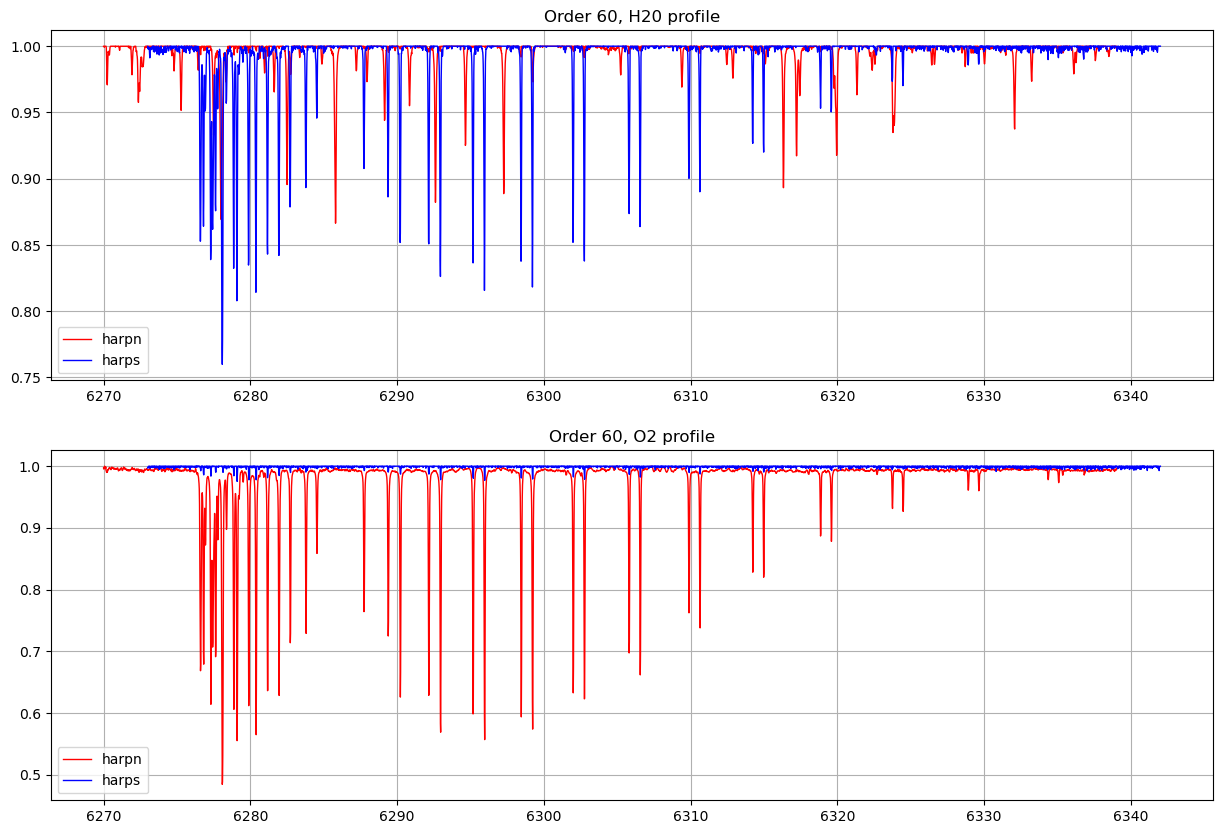

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].grid(True)
axs[0].plot(tell_hn[60, 0], tell_hn[60, 1], color='r', label='harpn', linewidth=1.0)
axs[0].plot(tell_hs[60, 0], tell_hs[60, 1], color='b', label='harps', linewidth=1.0)
axs[0].set_title('Order 60, H20 profile')
axs[0].legend()

axs[1].grid(True)
axs[1].plot(tell_hn[60, 0], tell_hn[60, 2], color='r', label='harpn', linewidth=1.0)
axs[1].plot(tell_hs[60, 0], tell_hs[60, 2], color='b', label='harps', linewidth=1.0)
axs[1].legend()
axs[1].set_title('Order 60, O2 profile')
fig.show()

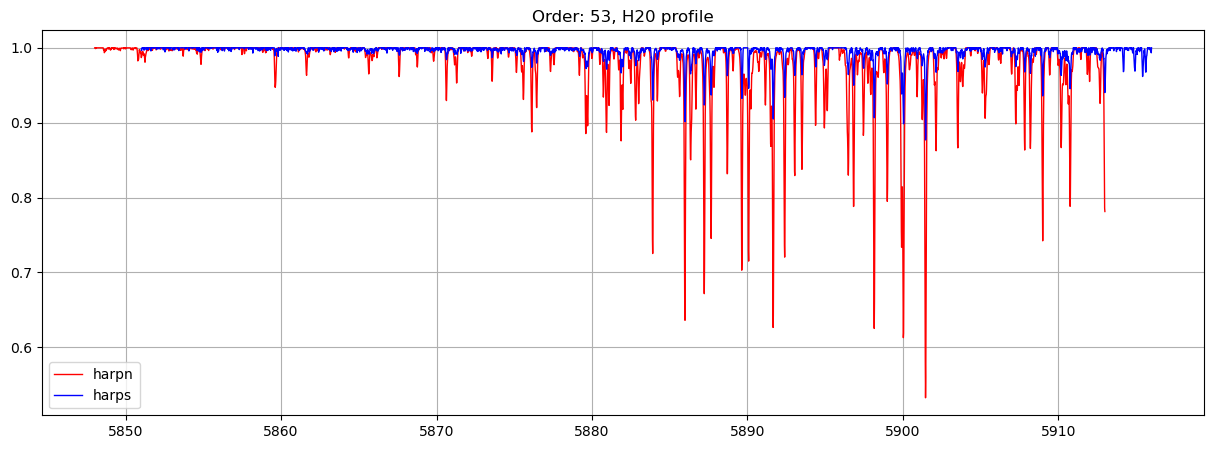

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True)
ax.plot(tell_hn[53, 0], tell_hn[53, 1], color='r', label='harpn', linewidth=1.0)
ax.plot(tell_hs[53, 0], tell_hs[53, 1], color='b', label='harps', linewidth=1.0)
ax.set_title('Order: 53, H20 profile')
ax.legend()
fig.show()

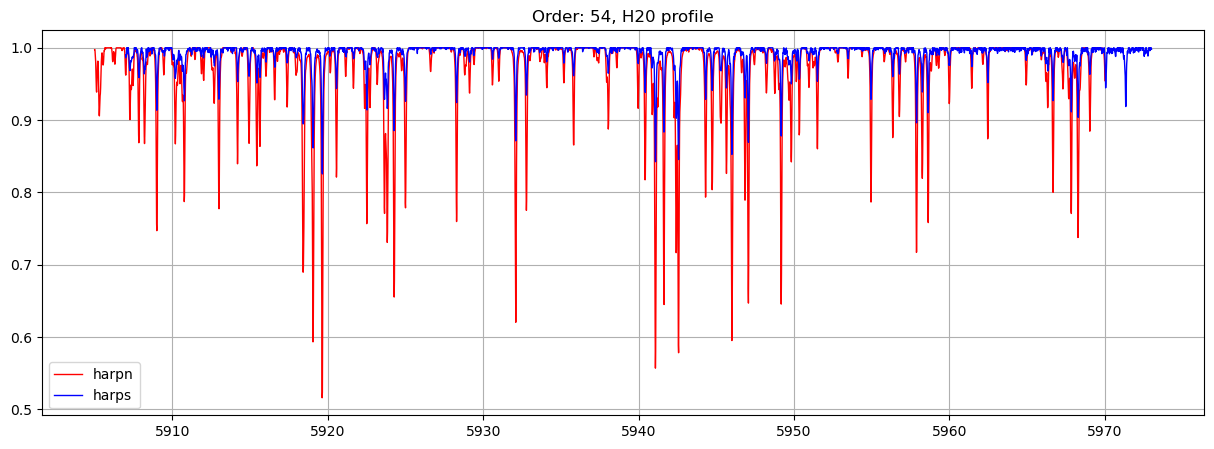

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True)
ax.plot(tell_hn[54, 0], tell_hn[54, 1], color='r', label='harpn', linewidth=1.0)
ax.plot(tell_hs[54, 0], tell_hs[54, 1], color='b', label='harps', linewidth=1.0)
ax.set_title('Order: 54, H20 profile')
ax.legend()
fig.show()

In [27]:
# telluric_spec[0] = h2o_weight * tell_hn[0, 1] + o2_weight * tell_hn[0, 2]
telluric_spec.shape, telluric_spec_tau.shape

((317, 69, 4096), (317, 69, 4096))

In [28]:
wave_obs_load.shape, flux_obs_load.shape

((317, 69, 4096), (317, 69, 4096))

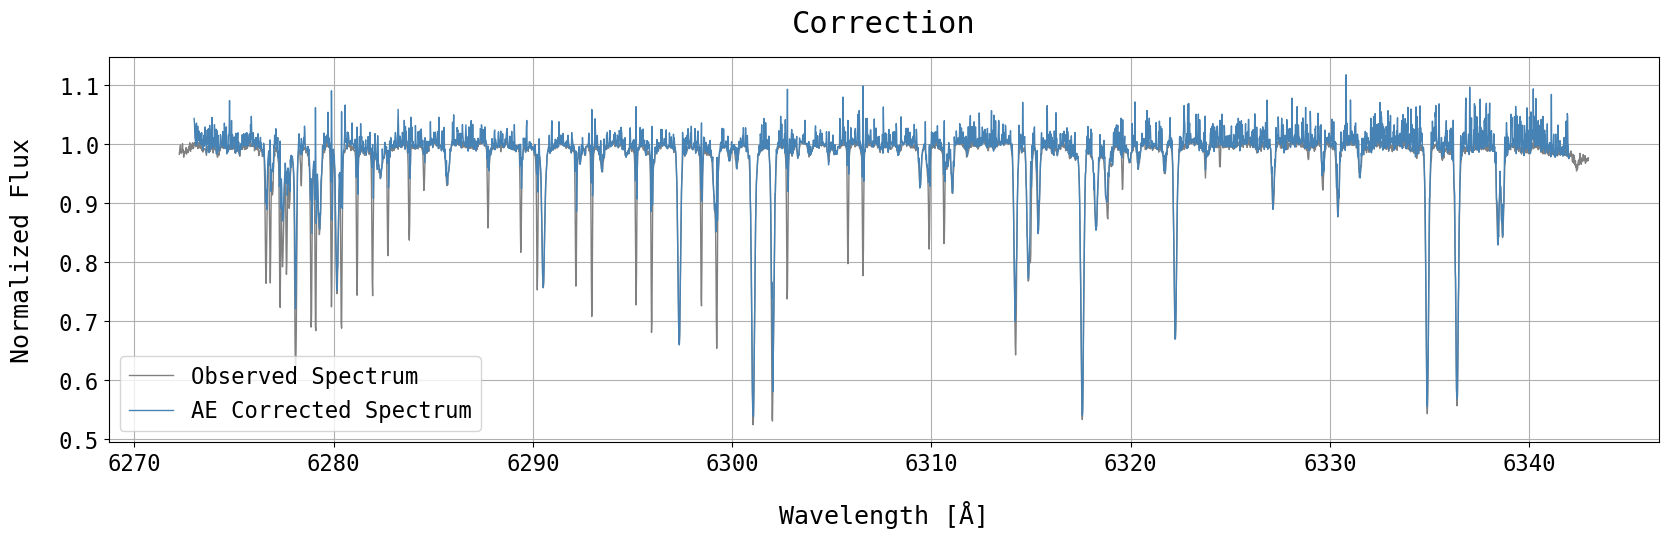

In [29]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(20, 5))
linewidth=1.0

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)

In [30]:
np.sqrt(np.nanmean((obs/cont - obs/telluric_spec[obs_nr,order]/cont) ** 2))

0.03682233174967374

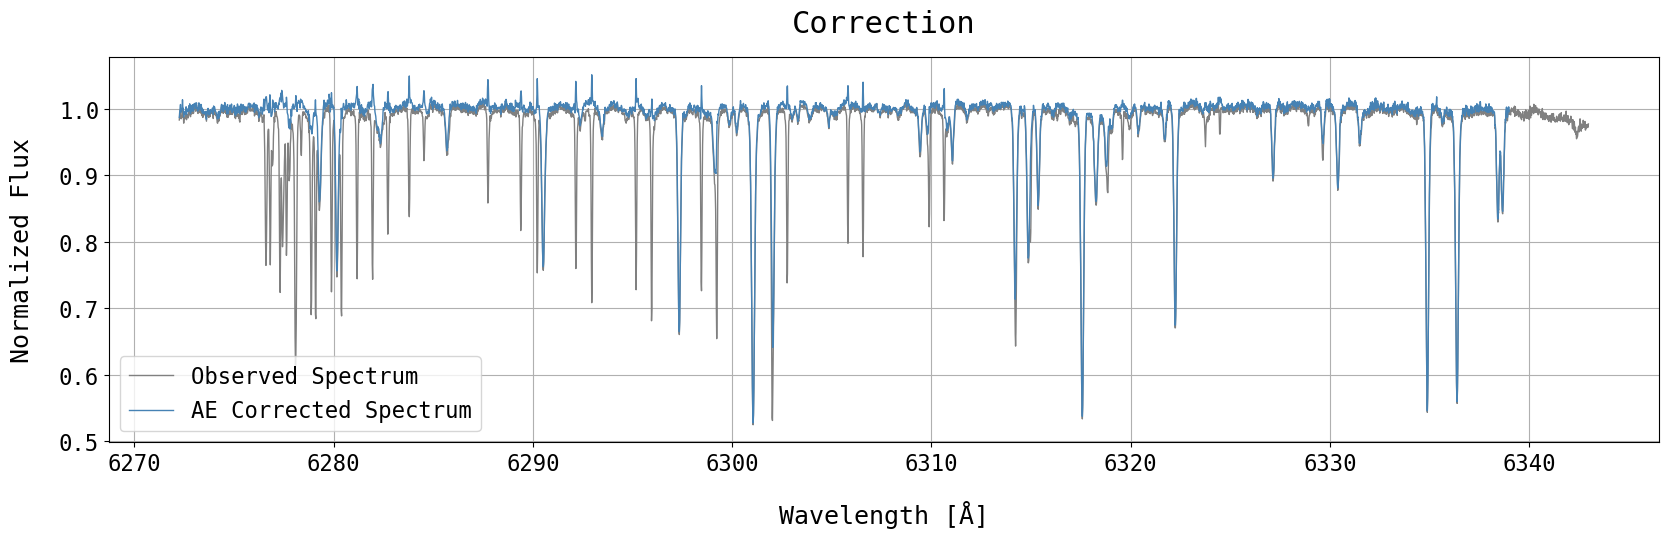

In [31]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(20, 5))
linewidth=1.0

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec_tau[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)

In [32]:
np.sqrt(np.nanmean((obs/cont - obs/telluric_spec_tau[obs_nr,order]/cont) ** 2))

0.043455651989331656

In [33]:
h2o_weight, o2_weight = zs[order][obs_nr, 1:].detach().cpu().numpy()
h2o_weight, o2_weight, H2O_weights[obs_nr], O2_weights[obs_nr]

(0.5567018, 0.8356241, 0.6236125585485965, 12.548440516682584)

In [34]:
# Applying fitted weights to all orders
Data1 =  tell_hn[:,1]*h2o_weight + (1-h2o_weight)
Data2 =  tell_hn[:,2]*o2_weight  + (1-o2_weight)

# Combining H2O and O2 spectra
AE_combined = Data1*Data2
AE_combined = np.clip(AE_combined,0,1) # If the weights are very large control that there is not negative transmission

# Interpolating combined AE to observed
wave = tell_hn[:,0]
AE_interp = np.zeros(wave_obs_load.shape)
for i in range(0,69): 
    f = interpolate.interp1d(wave[i], AE_combined[i],bounds_error=False,fill_value=np.nan,kind='quadratic')
    AE_interp[obs_nr,i, :]  = f(wave_obs_load[obs_nr, i, :])


In [35]:
AE_interp.shape

(317, 69, 4096)

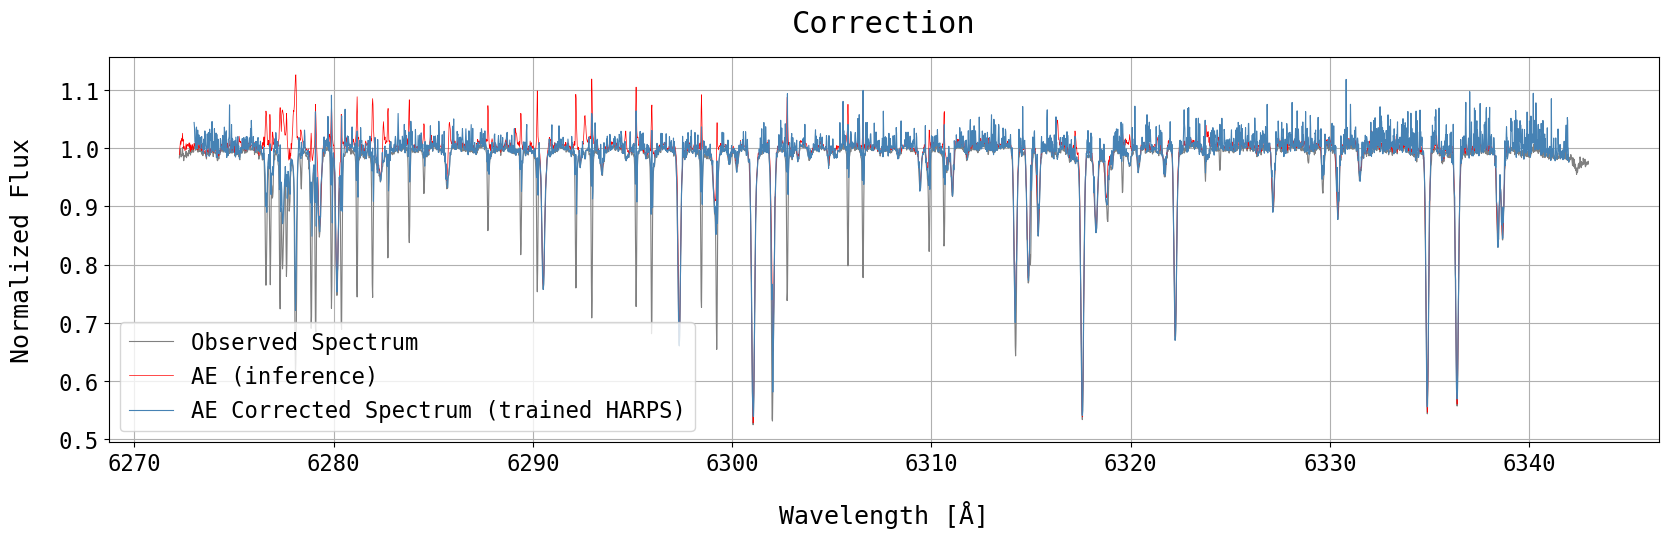

In [36]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(20, 5))
linewidth=0.8

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/AE_interp[obs_nr,order]/cont,color='red',label='AE (inference)',linewidth=0.5)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum (trained HARPS)',linewidth=linewidth)

#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)

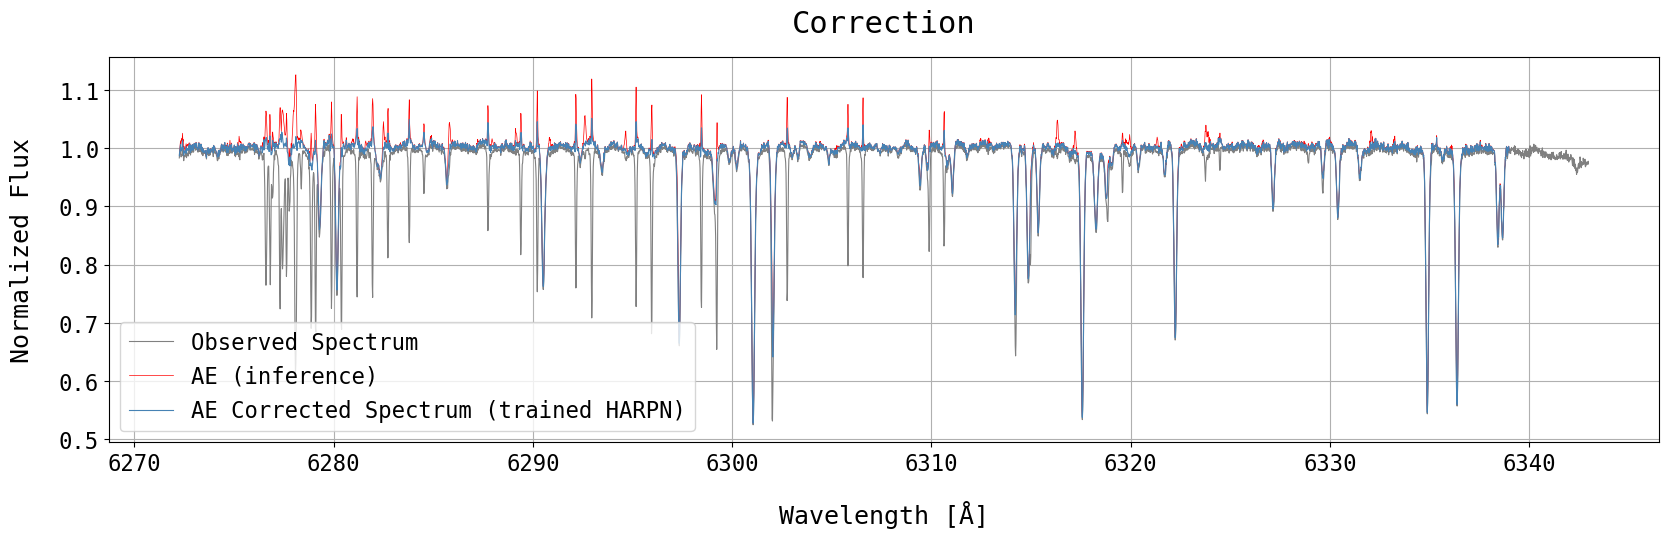

In [37]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(20, 5))
linewidth=0.8

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/AE_interp[obs_nr,order]/cont,color='red',label='AE (inference)',linewidth=0.5)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec_tau[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum (trained HARPN)',linewidth=linewidth)

#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)

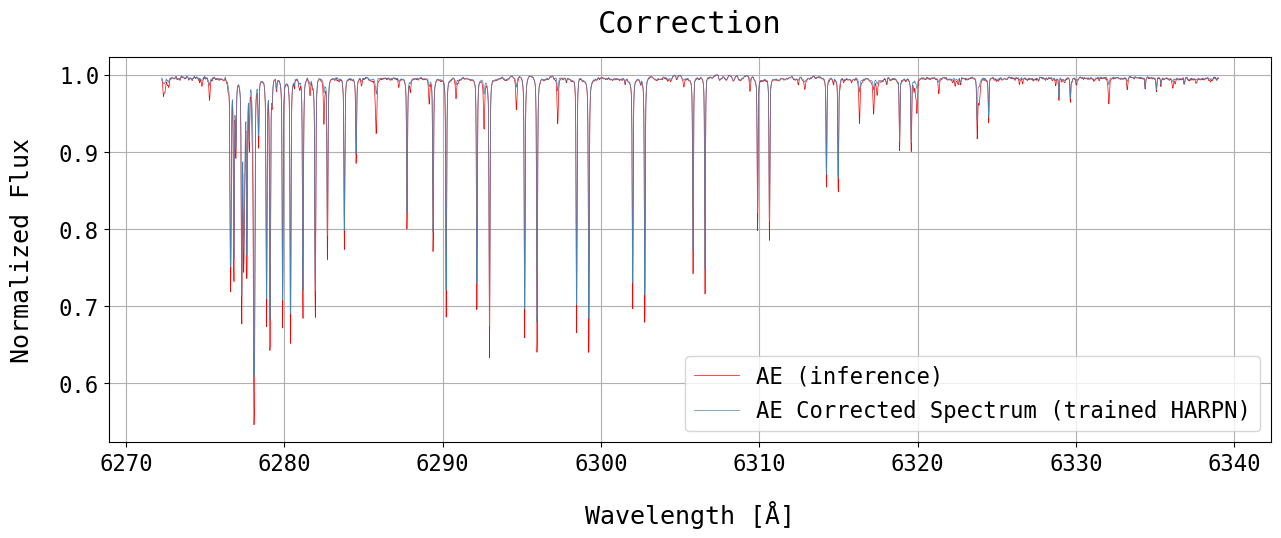

In [38]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(15, 5))
linewidth=0.5

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],AE_interp[obs_nr, order], color='red',label='AE (inference)', linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],telluric_spec_tau[obs_nr,order],color='steelblue',label='AE Corrected Spectrum (trained HARPN)',linewidth=linewidth)

#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)

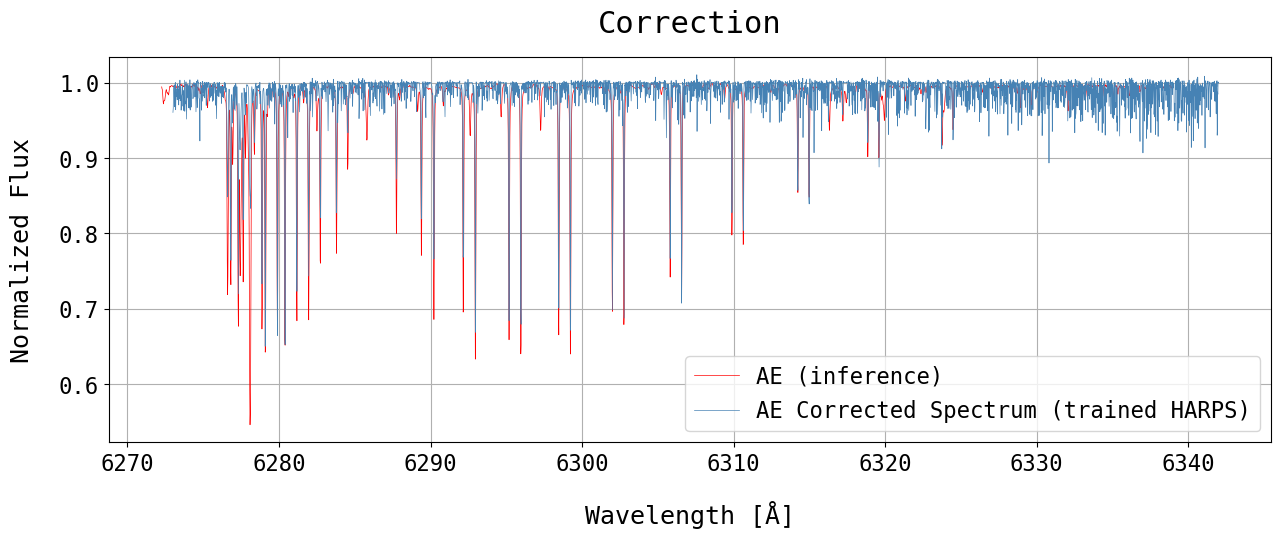

In [39]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(15, 5))
linewidth=0.5

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],AE_interp[obs_nr, order], color='red',label='AE (inference)', linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],telluric_spec[obs_nr,order],color='steelblue',label='AE Corrected Spectrum (trained HARPS)',linewidth=linewidth)

#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)